In [1]:
import numpy as np
import gym
from gym import Env, spaces, utils
import pygame
from typing import Optional
from io import StringIO
from contextlib import closing
from gym.spaces import Discrete
from gym.wrappers import FlattenObservation
import os

https://github.com/tensorflow/agents/blob/master/docs/tutorials/9_c51_tutorial.ipynb

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import PIL.Image
import pyvirtualdisplay


from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import categorical_q_network, q_network
from tf_agents.policies import random_tf_policy, greedy_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

import tensorflow as tf

In [3]:
from env_2048 import *

In [4]:
# from IPython.display import clear_output
# env = BlockDoubleEnv()
# env.reset()  # reset enviornment to default state
# score = 0
# while True:
#     check = 0
#     print(env.render())
#     key = input("w,a,s,d\n").lower()
#     if key == "w":
#         action = 3
#     elif key == "d":
#         action = 0
#     elif key == "s":
#         action = 1
#     elif key == "a":
#         action = 2
#     else:
#         break
#     clear_output()
#     new_state, reward, done, info = env.step(action)

### Hyperparamaters

In [5]:
num_iterations = 100 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_capacity = 100000  # @param {type:"integer"}

fc_layer_params = (100,)

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
gamma = 0.99
log_interval = 200  # @param {type:"integer"}

num_atoms = 51  # @param {type:"integer"}
min_q_value = -20  # @param {type:"integer"}
max_q_value = 20  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [6]:
env = BlockDoubleEnv()

In [7]:
train_py_env = suite_gym.wrap_env(BlockDoubleEnv())
eval_py_env = suite_gym.wrap_env(BlockDoubleEnv())
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [76]:
from tensorflow.keras.layers import Rescaling
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    preprocessing_layers = Rescaling(scale=1./2048),
    #num_atoms=num_atoms,
    fc_layer_params=fc_layer_params)

In [74]:
# https://github.com/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb
from tf_agents.specs import tensor_spec
from tf_agents.networks import sequential
fc_layer_params = (100, )
action_tensor_spec = tensor_spec.from_spec(train_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential([Rescaling(scale=1./2048)] + dense_layers + [q_values_layer])

In [77]:
q_net.build((4,4))
q_net.summary()

Model: "QNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  0         
_________________________________________________________________
dense_23 (Dense)             multiple                  0 (unused)
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


AttributeError: 'QNetwork' object has no attribute 'compile'

In [59]:
action_tensor_spec

BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0, dtype=int64), maximum=array(3, dtype=int64))

In [42]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network = q_net,
    # categorical_q_network=categorical_q_net,
    optimizer=optimizer,
    # min_q_value=min_q_value,
    # max_q_value=max_q_value,
    
    n_step_update=n_step_update,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=gamma,
    train_step_counter=train_step_counter)
agent.initialize()

ValueError: Expected q_network to emit a floating point tensor with inner dims (4,); but saw network output spec: TensorSpec(shape=(4, 4), dtype=tf.float32, name=None)
  In call to configurable 'DqnAgent' (<class 'tf_agents.agents.dqn.dqn_agent.DqnAgent'>)

In [25]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

compute_avg_return(eval_env, random_policy, num_eval_episodes)

# Please also see t

0.18

In [26]:
environment = eval_env
policy = agent.policy 

total_return = 0.0
for _ in range(10):

  time_step = environment.reset()
  episode_return = 0.0
  print("START")
  while not time_step.is_last():
    print(time_step.observation)
    action_step = policy.action(time_step)
    time_step = environment.step(action_step.action)
    episode_return += time_step.reward
  total_return += episode_return

avg_return = total_return / 10
avg_return.numpy()[0]

START
tf.Tensor(
[[[0 2 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]], shape=(1, 4, 4), dtype=int32)
tf.Tensor(
[[[0 0 0 0]
  [0 0 2 0]
  [0 0 0 0]
  [0 2 0 0]]], shape=(1, 4, 4), dtype=int32)
tf.Tensor(
[[[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]
  [0 2 2 2]]], shape=(1, 4, 4), dtype=int32)
tf.Tensor(
[[[0 2 2 2]
  [0 0 0 0]
  [0 0 0 0]
  [0 2 0 0]]], shape=(1, 4, 4), dtype=int32)
tf.Tensor(
[[[0 0 0 0]
  [0 0 0 0]
  [0 2 0 0]
  [0 4 2 2]]], shape=(1, 4, 4), dtype=int32)
START
tf.Tensor(
[[[0 0 0 0]
  [0 0 2 0]
  [0 0 0 0]
  [0 0 0 0]]], shape=(1, 4, 4), dtype=int32)
tf.Tensor(
[[[0 0 0 0]
  [0 0 2 0]
  [0 0 0 0]
  [0 0 2 0]]], shape=(1, 4, 4), dtype=int32)
tf.Tensor(
[[[0 0 0 2]
  [0 0 0 0]
  [0 0 0 0]
  [0 0 4 0]]], shape=(1, 4, 4), dtype=int32)
tf.Tensor(
[[[2 0 0 0]
  [0 0 0 0]
  [2 0 0 0]
  [4 0 0 0]]], shape=(1, 4, 4), dtype=int32)
tf.Tensor(
[[[0 0 0 0]
  [2 0 0 0]
  [4 0 0 0]
  [4 0 0 0]]], shape=(1, 4, 4), dtype=int32)
tf.Tensor(
[[[2 0 0 0]
  [0 0 0 2]
  [0 0 0 4]
  [0 0 0 4]]], shape=

0.14000002

In [27]:
compute_avg_return(eval_env, agent.policy, 2)

0.25

In [28]:
#@test {"skip": true}
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

def collect_step(environment, policy):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  replay_buffer.add_batch(traj)

for _ in range(initial_collect_steps):
  collect_step(train_env, random_policy)

# This loop is so common in RL, that we provide standard implementations of
# these. For more details see the drivers module.

# Dataset generates trajectories with shape [BxTx...] where
# T = n_step_update + 1.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=n_step_update + 1).prefetch(3)

iterator = iter(dataset)

In [34]:
num_iterations = 30000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_capacity = 100000  # @param {type:"integer"}

fc_layer_params = (100,)

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
gamma = 0.99
log_interval = 200  # @param {type:"integer"}

num_atoms = 51  # @param {type:"integer"}
min_q_value = -20  # @param {type:"integer"}
max_q_value = 20  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [35]:
#@test {"skip": true}
try:
  %%time
except:
  pass
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)
# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]
print('here')
for _ in range(num_iterations):
  #print(_)
  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    #print(_)
    collect_step(train_env, agent.collect_policy)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience)

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1:.2f}'.format(step, avg_return))
    returns.append(avg_return)

here
step = 200: loss = 0.0049532814882695675
step = 400: loss = 0.001281870063394308
step = 600: loss = 0.003277356270700693
step = 800: loss = 0.0025427057407796383
step = 1000: loss = 0.0034114865120500326
step = 1000: Average Return = 0.38
step = 1200: loss = 0.0015674165915697813
step = 1400: loss = 0.004530990030616522
step = 1600: loss = 0.0036992819514125586
step = 1800: loss = 0.007297265809029341
step = 2000: loss = 0.005207246169447899
step = 2000: Average Return = 0.37
step = 2200: loss = 0.004317179322242737
step = 2400: loss = 0.006819681264460087
step = 2600: loss = 0.010695701465010643
step = 2800: loss = 0.0042428141459822655
step = 3000: loss = 0.0019959257915616035
step = 3000: Average Return = 0.37
step = 3200: loss = 0.004787566140294075
step = 3400: loss = 0.0028667671140283346
step = 3600: loss = 0.0046587917022407055
step = 3800: loss = 0.0013107267441228032
step = 4000: loss = 0.00376956257969141
step = 4000: Average Return = 0.33
step = 4200: loss = 0.00401284

ValueError: x and y must have same first dimension, but have shapes (11,) and (21,)

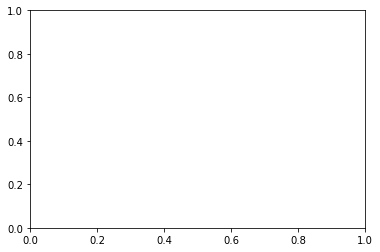

In [33]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Average Return')
plt.xlabel('Step')
#plt.ylim(top=550)

In [18]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [19]:
num_episodes = 3
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_py_env.render())
    while not time_step.is_last():
      action_step = agent.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_py_env.render())

embed_mp4(video_filename)

NeedDownloadError: Need ffmpeg exe. You can obtain it with either:
  - install using conda: conda install ffmpeg -c conda-forge
  - download using the command: imageio_download_bin ffmpeg
  - download by calling (in Python): imageio.plugins.ffmpeg.download()
